In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import nibabel as nib
import glob
import os
from nilearn.plotting import plot_stat_map, view_img


/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
reg = 'reward_par'
l2_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level2/model3_reg-rt0'
l2_imgs = glob.glob(os.path.join(l2_path, '*/*/*%s*'%(reg)))

## How can l3 t values be larger than the largest t values in the individual mean maps?

Is it because they are enhanced TFCE statistics instaed of raw T stats?

When I tried voxelwise setting `tfce=False` and checked the min and max values in `randomise_results.outputs.tstat_files` they were the same as the outputs using tfce. So, I think it's not about the TFCE but the **smoothing**.

Below are the min and max values along with their locations in each l2 image.

In [6]:
for img in l2_imgs:
    tmp = nib.load(img)
    tmp_data = tmp.get_fdata()
    print(round(np.min(tmp_data), 3), np.unravel_index(np.argmin(tmp_data, axis=None), tmp_data.shape), round(np.max(tmp_data), 3), np.unravel_index(np.argmax(tmp_data, axis=None), tmp_data.shape))
    

-3.636 (71, 65, 62) 5.279 (37, 68, 30)
-4.759 (68, 46, 67) 4.477 (33, 46, 41)
-4.556 (19, 69, 41) 4.553 (57, 99, 44)
-4.377 (58, 22, 14) 5.056 (70, 93, 35)
-4.354 (72, 76, 47) 4.164 (55, 68, 29)
-4.639 (37, 36, 63) 4.073 (52, 73, 47)
-4.753 (53, 30, 48) 5.096 (30, 48, 16)
-4.096 (24, 51, 41) 5.237 (44, 17, 34)
-4.282 (52, 30, 66) 4.196 (39, 71, 37)
-3.995 (47, 48, 33) 4.777 (45, 52, 64)
-4.641 (82, 62, 55) 5.088 (59, 64, 50)
-4.509 (53, 34, 57) 5.152 (32, 66, 46)
-4.228 (65, 63, 44) 4.4 (60, 89, 30)
-3.684 (48, 65, 32) 5.773 (34, 61, 35)
-4.582 (75, 69, 23) 4.926 (37, 52, 39)
-3.82 (44, 92, 31) 5.057 (46, 86, 41)
-4.221 (27, 66, 36) 4.333 (34, 93, 53)
-4.418 (64, 46, 64) 4.53 (33, 59, 21)
-4.66 (53, 43, 54) 5.318 (62, 25, 50)
-4.089 (35, 52, 40) 4.412 (39, 36, 27)
-4.511 (41, 70, 70) 4.35 (35, 21, 45)
-3.655 (44, 59, 52) 4.509 (57, 92, 50)
-4.811 (31, 19, 41) 5.097 (21, 52, 41)
-4.649 (37, 60, 24) 4.218 (34, 35, 24)
-4.886 (35, 92, 58) 4.938 (78, 45, 63)


A few example l2 images

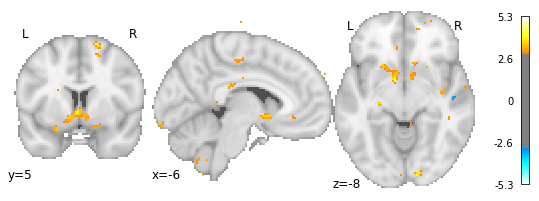

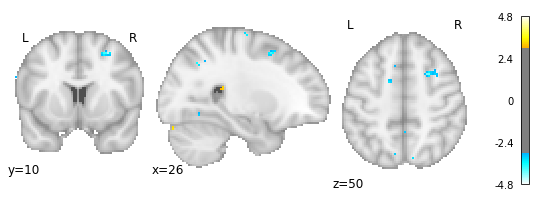

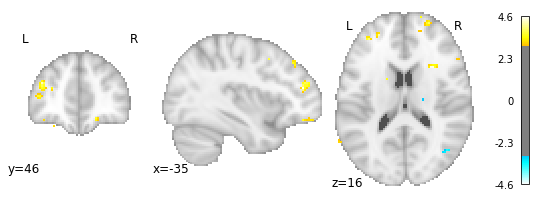

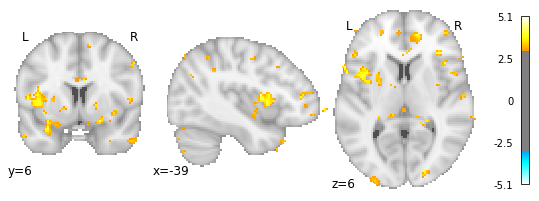

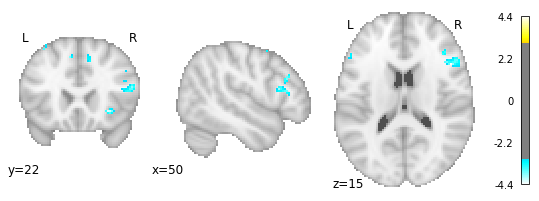

In [13]:
for img in l2_imgs[:5]:
    plot_stat_map(img, threshold=3, draw_cross=False)

## The average l2 image

In [17]:
l3_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level3/model3_reg-rt0/overall-mean/%s_model3_reg-rt0'%(reg)
all_img = nib.load(os.path.join(l3_path, 'all-l2_overall-mean_%s_model3_reg-rt0.nii.gz'%(reg)))

In [26]:
ave_img_data = np.mean(all_img.get_fdata(), axis=3) #average across subjects

In [50]:
ave_img = nib.Nifti1Image(ave_img_data.astype(np.float64), all_img.affine)

### No smoothing --> very noisy averages

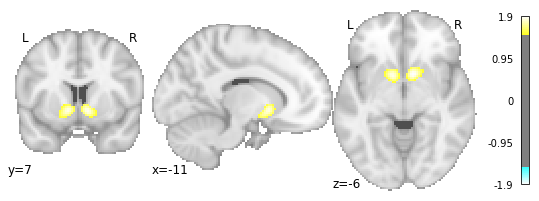

In [51]:
plot_stat_map(ave_img, threshold=1.5, draw_cross=False)

## What do l2 images look like with TFCE?

In [30]:
tfce_imgs = glob.glob(os.path.join(l2_path, '*/*tfce*'))

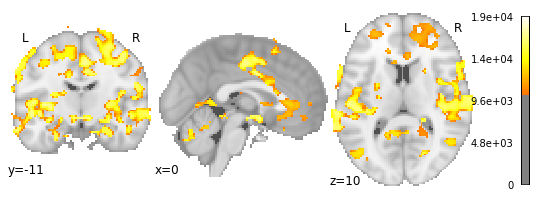

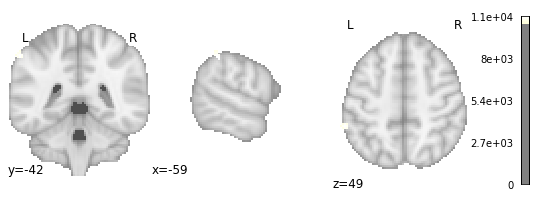

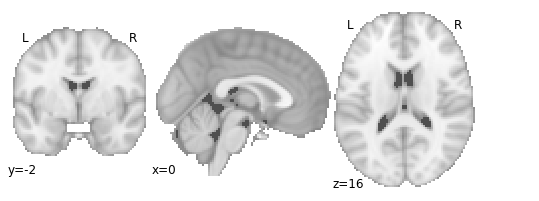

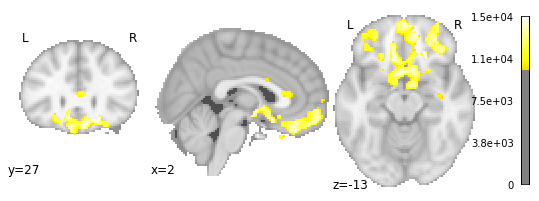

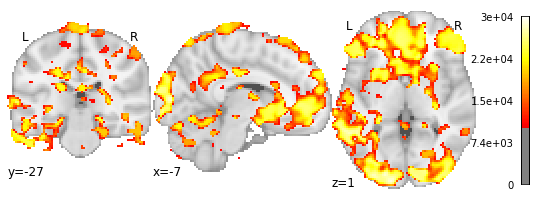

In [36]:
for img in tfce_imgs[:5]:
    plot_stat_map(img, threshold=10335, draw_cross=False) #Critical Value for: randomise_tfce_tstat1 is: 10335

In [42]:
from nilearn.image import concat_imgs, smooth_img, mean_img, math_img, resample_to_img

In [44]:
smooth_l2s = []
for l in tfce_imgs:
    smooth_l2 = smooth_img(l, 5)
    smooth_l2s.append(smooth_l2)
all_tfce_images = concat_imgs(smooth_l2s, auto_resample=True)

Average TFCE image

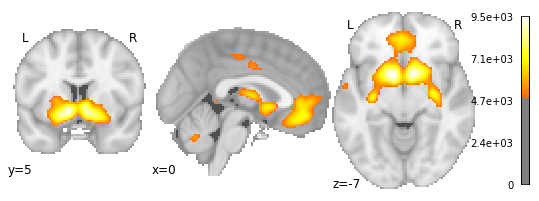

In [49]:
ave_tfce_img_data = np.mean(all_tfce_images.get_fdata(), axis=3) #average across subjects
ave_tfce_img = nib.Nifti1Image(ave_tfce_img_data.astype(np.float64), all_tfce_images.affine)
plot_stat_map(ave_tfce_img, threshold=5000, draw_cross=False)

## Run level3 analysis using nilearn instead of randomise

In [54]:
from nilearn.glm.second_level import SecondLevelModel

In [57]:
# 1's for all runs to get average for subject per contrast
design_matrix = pd.DataFrame([1] * len(l2_imgs), columns=['intercept'])
model = SecondLevelModel(smoothing_fwhm=5.0)

model = model.fit(l2_imgs, design_matrix=design_matrix)

z_map = model.compute_contrast(output_type='z_score')

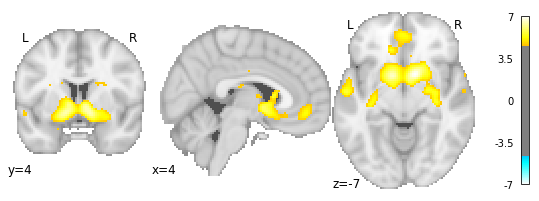

In [60]:
plot_stat_map(z_map, threshold=4.6, draw_cross=False)

### Compared to the randomise output

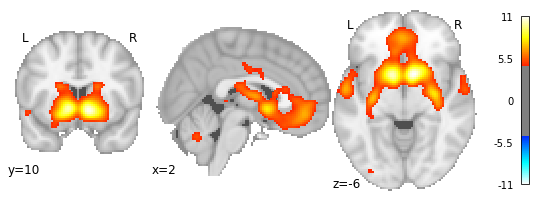

In [62]:
plot_stat_map(os.path.join(l3_path, 'rand_tfce_tstat1_pos_overall-mean_reward_par_model3_reg-rt0.nii.gz'), threshold = 4.6, draw_cross=False)